<a href="https://colab.research.google.com/github/Mubasshir-Ali/Deep_Learning_Practice/blob/master/13_Color_Images_Flowers_Saving_And_Loading_Models_Using_CNNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.8.0)
     |████████████████████████████████| 3.3MB 2.8MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

#Download the Flowers Dataset using TensorFlow Datasets
In the cell below you will download the Flowers dataset using TensorFlow Datasets. If you look at the TensorFlow Datasets documentation you will see that the name of the Flowers dataset is tf_flowers. You can also see that this dataset is only split into a TRAINING set. You will therefore have to use tfds.splits to split this training set into to a training_set and a validation_set. Do a [70, 30] split such that 70 corresponds to the training_set and 30 to the validation_set. Then load the tf_flowers dataset using tfds.load. Make sure the tfds.load function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.

In [0]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    split = ['train[:70%]', 'train[70%:]'], 
    with_info = True,
    as_supervised = True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


# Print Information about the Flowers Dataset
Now that you have downloaded the dataset, use the dataset info to print the number of classes in the dataset, and also write some code that counts how many images we have in the training and validation sets.

In [0]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number Of Classes: {}'.format(num_classes))
print('Total Number Of Training Images: {}'.format(num_training_examples))
print('Total Number Of Validation Images: {} \n'.format(num_validation_examples))

Total Number Of Classes: 5
Total Number Of Training Images: 2569
Total Number Of Validation Images: 1101 



In [0]:
# The images in the Flowers dataset are not all the same size.
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformat Images and Create Batches
In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function should take in an image and a label as arguments and should return the new image and corresponding label. Then create training and validation batches of size 32.

In [0]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Create a Feature Extractor
In the cell below create a feature_extractor using MobileNet v2. Remember that the partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. Go to the TensorFlow Hub documentation to see a list of available feature vectors. Click on the tf2-preview/mobilenet_v2/feature_vector. Read the documentation and get the corresponding URL to get the MobileNet v2 feature vector. Finally, create a feature_extractor by using hub.KerasLayer with the correct input_shape parameter.

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, 
                                   input_shape = (IMAGE_RES, IMAGE_RES, 3))

# Freeze the Pre-Trained Model
In the cell below freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [0]:
feature_extractor.trainable = False

# Attach a classification head
In the cell below create a tf.keras.Sequential model, and add the pre-trained model and the new classification layer. Remember that the classification layer must have the same number of classes as our Flowers dataset. Finally print a summary of the Sequential model.

In [0]:
model = tf.keras.Sequential([
  feature_extractor, 
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


# Train the model
In the cell bellow train this model like any other, by first calling compile and then followed by fit. Make sure you use the proper parameters when applying both methods. Train the model for only 6 epochs.

In [0]:
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
    metrics = ['accuracy']
)

EPOCHS = 6

history = model.fit(train_batches, 
                    epochs = EPOCHS, 
                    validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 7s 92ms/step - loss: 0.8206 - accuracy: 0.6968 - val_loss: 0.4465 - val_accuracy: 0.8501
Epoch 2/6
81/81 [==============================] - 7s 86ms/step - loss: 0.3971 - accuracy: 0.8704 - val_loss: 0.3529 - val_accuracy: 0.8801
Epoch 3/6
81/81 [==============================] - 7s 85ms/step - loss: 0.3094 - accuracy: 0.8996 - val_loss: 0.3259 - val_accuracy: 0.8874
Epoch 4/6
81/81 [==============================] - 7s 85ms/step - loss: 0.2539 - accuracy: 0.9221 - val_loss: 0.2984 - val_accuracy: 0.8955
Epoch 5/6
81/81 [==============================] - 7s 87ms/step - loss: 0.2196 - accuracy: 0.9366 - val_loss: 0.2882 - val_accuracy: 0.9028
Epoch 6/6
81/81 [==============================] - 7s 87ms/step - loss: 0.1952 - accuracy: 0.9455 - val_loss: 0.2945 - val_accuracy: 0.8928


# Plot Training And Validation Graphs

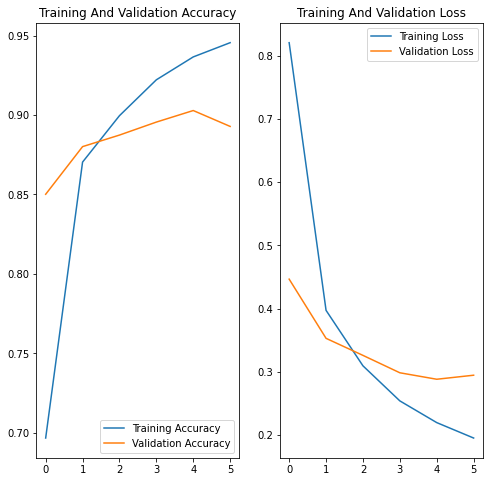

In [0]:
# In the cell below, plot the training and validation accuracy/loss graphs.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training And Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training And Validation Loss')
plt.show()

# Check Predictions

In [0]:
# In the cell below get the label names from the dataset info and convert them into a NumPy array. Print the array to make sure you have the correct label names.
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


# Create an Image Batch and Make Predictions
In the cell below, use the next() function to create an image_batch and its corresponding label_batch. Convert both the image_batch and label_batch to numpy arrays using the .numpy() method. Then use the .predict() method to run the image batch through your model and make predictions. Then use the np.argmax() function to get the indices of the best prediction for each image. Finally convert the indices of the best predictions to class names.

In [0]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['dandelion' 'tulips' 'roses' 'daisy' 'dandelion' 'dandelion' 'tulips'
 'roses' 'dandelion' 'tulips' 'tulips' 'daisy' 'roses' 'tulips'
 'dandelion' 'daisy' 'daisy' 'tulips' 'tulips' 'dandelion' 'sunflowers'
 'daisy' 'dandelion' 'dandelion' 'tulips' 'sunflowers' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'tulips']


# Print True Labels and Predicted Indices

In [0]:
# In the cell below, print the true labels and the indices of predicted labels.

print("Labels: ",label_batch)
print("Predicted Labels: ", predicted_ids)

Labels:  [0 2 4 1 0 0 2 4 0 2 2 1 4 2 0 1 1 0 2 0 3 1 0 0 2 3 0 2 3 4 3 2]
Predicted Labels:  [0 2 4 1 0 0 2 4 0 2 2 1 4 2 0 1 1 2 2 0 3 1 0 0 2 3 0 2 3 4 3 2]


# Plot Model Predictions

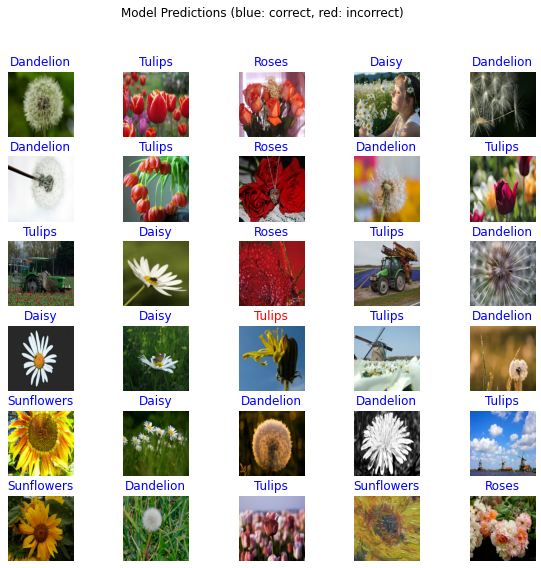

In [0]:
plt.figure(figsize = (10, 9))
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color = color)
  plt.axis('off')
  _ = plt.suptitle("Model Predictions (blue: correct, red: incorrect)")

# Perform Transfer Learning with the Inception Model
Go to the TensorFlow Hub documentation and click on tf2-preview/inception_v3/feature_vector. This feature vector corresponds to the Inception v3 model. In the cells below, use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

In [0]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info = True,
    as_supervised = True, 
    split = ['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, 
  input_shape = (IMAGE_RES, IMAGE_RES, 3), 
  trainable = False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes) 
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
model_inception.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
    metrics = ['accuracy']
)

EPOCHS = 6

history = model_inception.fit(train_batches, 
                    epochs = EPOCHS, 
                    validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 11s 139ms/step - loss: 0.7579 - accuracy: 0.7244 - val_loss: 0.4668 - val_accuracy: 0.8438
Epoch 2/6
81/81 [==============================] - 10s 120ms/step - loss: 0.3959 - accuracy: 0.8673 - val_loss: 0.3645 - val_accuracy: 0.8856
Epoch 3/6
81/81 [==============================] - 10s 121ms/step - loss: 0.3292 - accuracy: 0.8883 - val_loss: 0.3291 - val_accuracy: 0.8874
Epoch 4/6
81/81 [==============================] - 10s 120ms/step - loss: 0.2703 - accuracy: 0.9183 - val_loss: 0.3355 - val_accuracy: 0.8792
Epoch 5/6
81/81 [==============================] - 10s 120ms/step - loss: 0.2348 - accuracy: 0.9272 - val_loss: 0.2866 - val_accuracy: 0.8946
Epoch 6/6
81/81 [==============================] - 10s 121ms/step - loss: 0.2118 - accuracy: 0.9385 - val_loss: 0.2870 - val_accuracy: 0.9010


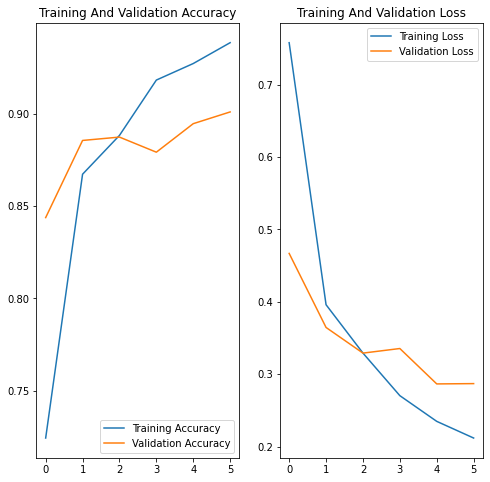

In [0]:
# In the cell below, plot the training and validation accuracy/loss graphs.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training And Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training And Validation Loss')
plt.show()

# Save as Keras .h5 Model
Now that we've trained the model, we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correpond to the current time stamp.



In [0]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1588625487.h5


In [0]:
!ls

1588625487.h5  sample_data


You can later recreate the same model from this file, even if you no longer have access to the code that created the model.

This file includes:

* The model's architecture
* The model's weight values (which were learned during training)
* The model's training config (what you passed to compile), if any
* The optimizer and its state, if any (this enables you to restart training where you left off)

# Load The Keras .h5 Model
We will now load the model we just saved into a new model called reloaded. We will need to provide the file path and the custom_objects parameter. This parameter tells keras how to load the hub.KerasLayer from the feature_extractor we used for transfer learning.

In [0]:
reloaded = tf.keras.models.load_model(
    export_path_keras, 
    # `custom_objects` tells keras how to load a `hub.KerasLayer`
    custom_objects = {'KerasLayer': hub.KerasLayer}
)

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# We can check that the reloaded model and the previous model give the same result
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [0]:
# The difference in output should be zero:
(abs(result_batch - reloaded_result_batch)).max()

0.0

# Keep Training
Besides making predictions, we can also take our reloaded model and keep training it. To do this, you can just train the reloaded as usual, using the .fit method.

In [0]:
EPOCHS = 6

history = model.fit(train_batches, 
                    epochs = EPOCHS, 
                    validation_data = validation_batches)

Epoch 1/6


ValueError: ignored

# Export as SavedModel
You can also export a whole model to the TensorFlow SavedModel format. SavedModel is a standalone serialization format for Tensorflow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. A SavedModel contains a complete TensorFlow program, including weights and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying (with TFLite, TensorFlow.js, TensorFlow Serving, or TFHub).

The SavedModel files that were created contain:
* A TensorFlow checkpoint containing the model weights.
* A SavedModel proto containing the underlying Tensorflow graph. Separate graphs are saved for prediction (serving), train, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
* The model's architecture config, if available.

Let's save our original model as a TensorFlow SavedModel. To do this we will use the tf.saved_model.save() function. This functions takes in the model we want to save and the path to the folder where we want to save our model.

This function will create a folder where you will find an assets folder, a variables folder, and the saved_model.pb file.

In [0]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1588626331
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./1588626331/assets


INFO:tensorflow:Assets written to: ./1588626331/assets


In [0]:
!ls{export_path_sm}

/bin/bash: ls./1588626331: No such file or directory


# Load SavedModel
Now, let's load our SavedModel and use it to make predictions. We use the tf.saved_model.load() function to load our SavedModels. The object returned by tf.saved_model.load is 100% independent of the code that created it.

In [0]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [0]:
# Now, let's use the reloaded_sm (reloaded SavedModel) to make predictions on a batch of images.
reload_sm_result_batch = reloaded_sm(image_batch, training = False).numpy()

In [0]:
# We can check that the reloaded SavedModel and the previous model give the same result.
(abs(result_batch - reload_sm_result_batch)).max()

0.0

# Loading the SavedModel as a Keras Model
The object returned by tf.saved_model.load is not a Keras object (i.e. doesn't have .fit, .predict, .summary, etc. methods). Therefore, you can't simply take your reloaded_sm model and keep training it by running .fit. To be able to get back a full keras model from the Tensorflow SavedModel format we must use the tf.keras.models.load_model function. This function will work the same as before, except now we pass the path to the folder containing our SavedModel.

In [0]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1588626415
INFO:tensorflow:Assets written to: ./1588626415/assets


INFO:tensorflow:Assets written to: ./1588626415/assets


In [0]:
reload_sm_keras = tf.keras.models.load_model(
    export_path_sm, 
    custom_objects = {'KerasLayer': hub.KerasLayer}
)

reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


# Download Your Model
You can download the SavedModel to your local disk by creating a zip file. We wil use the -r (recursice) option to zip all subfolders.

In [0]:
!zip -r flowers_model.zip {export_path_sm}

  adding: 1588626415/ (stored 0%)
  adding: 1588626415/variables/ (stored 0%)
  adding: 1588626415/variables/variables.data-00000-of-00002 (deflated 88%)
  adding: 1588626415/variables/variables.index (deflated 79%)
  adding: 1588626415/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: 1588626415/saved_model.pb (deflated 92%)
  adding: 1588626415/assets/ (stored 0%)


In [0]:
# The zip file is saved in the current working directory. You can see what the current working directory is by running:
!ls

1588625487.h5  Color_Images_Flowers_Saving_And_Loading_Models_Using_CNNS.zip
1588626331     flowers_model.zip
1588626415     sample_data


In [0]:
# Once the file is zipped, you can download it to your local disk
try:
  from google.colab import files
  files.download('./flowers_model.zip')
except ImportError:
  pass